In [1]:
!pip install -q gdown

In [2]:
!gdown --id 1GOU3sgc-8Dq3prCbSQme59oHr2jZpn9r -O noisy_pepper.png

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GOU3sgc-8Dq3prCbSQme59oHr2jZpn9r
To: /content/noisy_pepper.png
100% 174k/174k [00:00<00:00, 29.6MB/s]


Load the noisy image from the google drive.

In [7]:
!pip install -q imageio

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

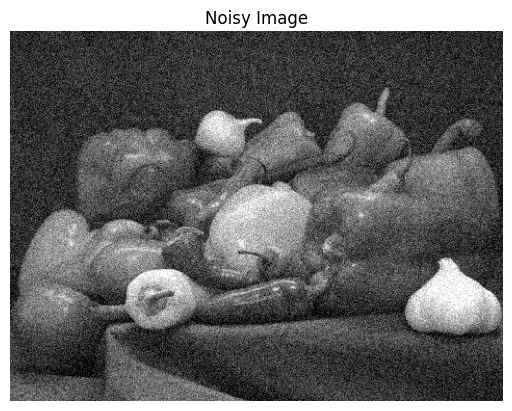

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy.signal import convolve2d
import time

noisy_img = imageio.imread("/content/noisy_pepper.png")

plt.figure(1)
plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy Image")
plt.axis("off")

Let's make a 2D discrete Gaussian kernel:

$G(x, y) = \frac{1}{2 \pi \sigma^2} \exp\Bigg(-\frac{x^2 + y^2}{2\sigma^2}\Bigg)$

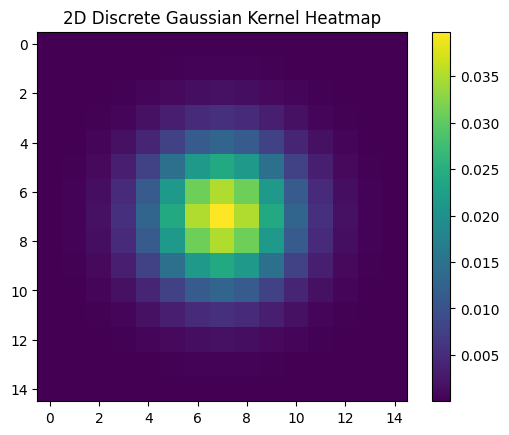

In [40]:
def gaussian_2d_kernel(size=5, sigma=1.0):
    """
    Create a 2D discrete Gaussian kernel
    """
    ax = np.linspace(-(size-1)/2., (size-1)/2., size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0*sigma**2))
    return kernel / np.sum(kernel)

gauss_kernel_2d = gaussian_2d_kernel(size=15, sigma=2)

# Visualize the kernel as a heatmap
plt.imshow(gauss_kernel_2d, cmap='viridis')
plt.colorbar()
plt.title("2D Discrete Gaussian Kernel Heatmap")
plt.show()

Gaussian convolving the image took 0.14594 seconds


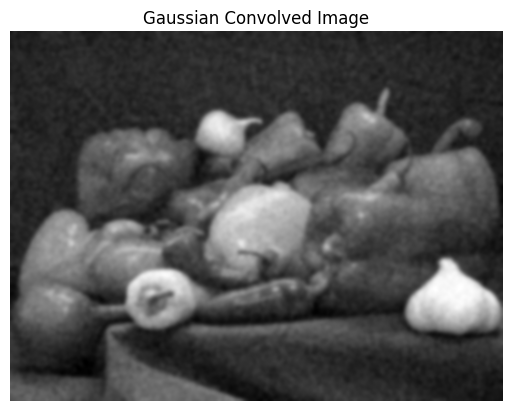

In [41]:
start_time = time.time()

denoised_img = convolve2d(noisy_img, gauss_kernel_2d, mode='same', boundary='symm')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Gaussian convolving the image took {elapsed_time:.5f} seconds")

plt.imshow(denoised_img, cmap='gray')
plt.title("Gaussian Convolved Image")
plt.axis('off')

plt.show()

The Gaussian convolved image seems to be very blurry. However, keep in mind that we process the images for the computer to "see". The blurry image helps the computer to recognize the real signal such as the shape of the peppers instead of being distracted by the noise. Applying an edge detector shows a huge difference in the detected edges between the noisy image and the Gaussian convolved image.

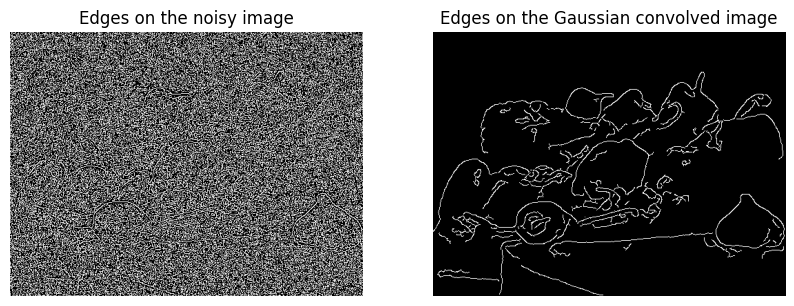

In [48]:
import cv2

# Convert to uint8
noisy_img_uint8 = np.clip(noisy_img, 0, 255).astype(np.uint8)
denoised_img_uint8 = np.clip(denoised_img, 0, 255).astype(np.uint8)

# Canny edge detection
edges_on_noisy_img = cv2.Canny(noisy_img_uint8, threshold1=10, threshold2=80)
edges_on_denoised_img = cv2.Canny(denoised_img_uint8, threshold1=10, threshold2=80)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(edges_on_noisy_img, cmap='gray')
plt.title("Edges on the noisy image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges_on_denoised_img, cmap='gray')
plt.title("Edges on the Gaussian convolved image")
plt.axis('off')
plt.show()

A 2D $N \times N$ Gaussian and be decomposed into two 1D Gaussian with the same sigma.

$G(x, y) = G_x(x) \cdot G_y(y)$

where
$G_x(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\Big(-\frac{x^2}{2\sigma^2}\Big), \quad
G_y(y) = \frac{1}{\sqrt{2\pi}\sigma} \exp\Big(-\frac{y^2}{2\sigma^2}\Big)$

The separable property of the kernel is beneficial in terms of computational efficiency when convolving the image.

Specifically, the process starts by convolving the image with a $N \times 1$ kernel in the vertical direction, then convolving the result with a $1 \times N$ kernel in the horizontal direction. The first vertical 1D convolution requires $N$ multiplications while the horizontal 1D convolution needs $N$ multiplications; thus only $N+N=2N$ products are necessary per output pixel, as opposed to $N \times N$ if a 2D convolution is directly applied.

Separable Gaussian convolving the image took 0.01354 seconds


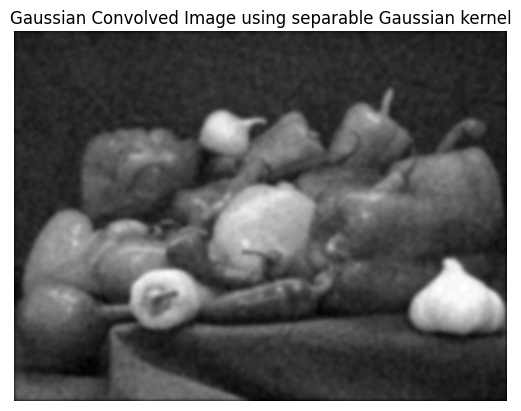

In [49]:
from scipy.signal import convolve

def gaussian_1d_kernel(size=5, sigma=1.0):
    ax = np.linspace(-(size-1)/2., (size-1)/2., size)
    kernel = np.exp(-0.5 * (ax / sigma)**2)
    return kernel / np.sum(kernel)

gauss_kernel_1d = gaussian_1d_kernel(size=15, sigma=2)

start_time = time.time()

# Convolve along rows
convolve_rows = convolve(noisy_img, gauss_kernel_1d[np.newaxis, :], mode='same')

# Convolve along columns
denoised_img_sep = convolve(convolve_rows, gauss_kernel_1d[:, np.newaxis], mode='same')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Separable Gaussian convolving the image took {elapsed_time:.5f} seconds")

plt.imshow(denoised_img_sep, cmap='gray')
plt.title("Gaussian Convolved Image using separable Gaussian kernel")
plt.axis('off')
plt.show()